# AI-LAB SESSION 3: Markov Decision Process

In the third session we will work on the Markov decision process (MDP)

## Lava environments
The environments used are LavaFloor (visible in the figure) and its variations.

![Lava](images/lava.png)

The agent starts in cell $(0, 0)$ and has to reach the treasure in $(2, 3)$. In addition to the walls of the previous environments, the floor is covered with lava, there is a black pit of death.

Moreover, the agent can't comfortably perform its actions that instead have a stochastic outcome (visible in the figure):

![Dynact](images/dynact.png)

The action dynamics is the following:
- $P(0.8)$ of moving in the desired direction
- $P(0.1)$ of moving in a direction 90° with respect to the desired direction

Finally, since the floor is covered in lava, the agent receives a negative reward for each of its steps!

- -0.04 for each lava cell (L)
- -5 for the black pit (P). 
- +1 for the treasure (G). 

In [1]:
import os, sys
module_path = os.path.abspath(os.path.join('../tools'))
if module_path not in sys.path:
    sys.path.append(module_path)

import gym, envs
import numpy as np
from utils.ai_lab_functions import *
from timeit import default_timer as timer
from tqdm import tqdm as tqdm

### Environment Properties 

In addition to the varables of the environments you have been using in the previous sessions, there are also a few more:

- $T$: matrix of the transition function $T(s, a, s') \rightarrow [0, 1]$
- $RS$: matrix of the reward function $R(s) \rightarrow \mathbb{R}$

The available actions are still Left, Right, Up, Down.

#### Code Hints:

In [2]:
env = gym.make("NiceLavaFloor-v0")

current_state = env.pos_to_state(0, 0)
next_state = env.pos_to_state(0, 1)
goal_state = env.pos_to_state(2, 3)

print("Number of actions: ", env.action_space.n)
print("Actions: ", env.actions)
print("Reward:\n", np.asarray(env.RS).reshape(env.rows, env.cols))
print("Reward of goal state:", env.RS[goal_state])
print("Probability from (0, 1) to (0, 0) with action left:", env.T[next_state, 3, current_state])
print("Probability from (0, 0) to (2, 3) with action left:", env.T[current_state, 1, goal_state])

Number of actions:  4
Actions:  {0: 'L', 1: 'R', 2: 'U', 3: 'D'}
Reward:
 [[ 50.  50.  50.  50.]
 [ 50.   0.  50. -50.]
 [ 50.  50.  50.   5.]]
Reward of goal state: 5.0
Probability from (0, 1) to (0, 0) with action left: 0.1
Probability from (0, 0) to (2, 3) with action left: 0.0


### Assignment 1: Value Iteration Algorithm

Your first assignment is to implement the Value Iteration algorithm on LavaFloor. The solution returned by your algorithm must be a 1-d array of action identifiers where the $i$-th action refers to the $i$-th state.  You can perform all the test on different versions of the environment, but with the same structure: *HugeLavaFloor*, *NiceLavaFloor* and *VeryBadLavaFloor*.

<img src="images/value-iteration.png" width="600">

You must implement the *value_iteration* function. Notice that the value iteration approach return a matrix with the value for eacht state, the function *values_to_policy* automatically convert this matrix in the policy.

In [3]:
def value_iteration(problem, maxiters=150, discount=0.9, max_error=1e-3):
    """
    Performs the value iteration algorithm for a specific environment
    
    Args:
        problem: OpenAI Gym environment
        maxiters: timeout for the iterations
        discount: gamma value, the discount factor for the Bellman equation
        max_error: the maximum error allowd in the utility of any state
        
    Returns:
        policy: 1-d dimensional array of action identifiers where index `i` corresponds to state id `i`
    """
    
    U_1 = [0 for _ in range(problem.observation_space.n)] # vector of utilities for states S
    #delta = 0 # maximum change in the utility o any state in an iteration
    iterations = 0
    
    while True:           
        iterations = iterations + 1        
        delta = 0
        U = U_1.copy()
        for state in range(problem.observation_space.n):
            # calcolo della sommatoria 
            sum_action = [0 for _ in range(problem.action_space.n)]            
            for action in range(problem.action_space.n):                
                for next_state in range(problem.observation_space.n):                    
                    sum_action[action] += problem.T[state, action, next_state] * U[next_state]                    
            U_1[state] = problem.RS[state] + discount * np.max(sum_action)            
            if abs(U_1[state] - U[state]) > delta: delta = abs(U_1[state] - U[state])         
        if delta < (max_error * (1 - discount) / discount): break   
        if iterations >= maxiters: break 
            
    return values_to_policy(np.asarray(U), env) # automatically convert the value matrix U to a policy

The following code executes and Value Iteration and prints the resulting policy

In [4]:
envname = "LavaFloor-v0"
#envname = "VeryBadLavaFloor-v0"
#envname = "NiceLavaFloor-v0"

print("\n----------------------------------------------------------------")
print("\tEnvironment: {} \n\tValue Iteration".format(envname))
print("----------------------------------------------------------------")

env = gym.make(envname)
print("\nRENDER:")
env.render()

t = timer()
policy = value_iteration(env)

print("\nTIME: \n{}".format(round(timer() - t, 4)))
print("\nPOLICY:")
print(np.vectorize(env.actions.get)(policy.reshape(env.rows, env.cols)))


----------------------------------------------------------------
	Environment: LavaFloor-v0 
	Value Iteration
----------------------------------------------------------------

RENDER:
[['S' 'L' 'L' 'L']
 ['L' 'W' 'L' 'P']
 ['L' 'L' 'L' 'G']]

TIME: 
0.2137

POLICY:
[['D' 'L' 'L' 'U']
 ['D' 'L' 'L' 'L']
 ['R' 'R' 'R' 'L']]


Correct results can be found [here](lesson_3_results.txt).

### Assignment 2: Policy Iteration Algorithm

Your first assignment is to implement the Policy Iteration algorithm on LavaFloor. The solution returned by your algorithm must be a 1-d array of action identifiers where the $i$-th action refers to the $i$-th state. You can perform all the test on different versions of the environment, but with the same structure: *HugeLavaFloor*, *NiceLavaFloor* and *VeryBadLavaFloor*.

<img src="images/policy-iteration.png" width="600">

For the *policy evaluation step*, implement this function repeating the update for an arbitrary number of steps (e.g., 10):

<img src="images/policy-evaluating.png" width="500">

In [5]:
def policy_iteration(problem, maxiters=150, discount=0.9, max_error=1e-3):
    """
    Performs the policy iteration algorithm for a specific environment
    
    Args:
        problem: OpenAI Gym environment
        maxiters: timeout for the iterations
        discount: gamma value, the discount factor for the Bellman equation
        
    Returns:
        policy: 1-d dimensional array of action identifiers where index `i` corresponds to state id `i`
    """
    
    policy = [0 for _ in range(problem.observation_space.n)] #initial policy
    U = [0 for _ in range(problem.observation_space.n)] #utility array
    iterations = 0
    
    while True:
        iterations = iterations + 1
        # Step (1): Policy Evaluation        
        while True:    
            delta = 0
            U_1 = U.copy()
            for state in range(problem.observation_space.n):
                # calcolo della sommatoria 
                sum_state = 0
                for next_state in range(problem.observation_space.n):                    
                    sum_state += problem.T[state, policy[state], next_state] * U[next_state]  
                U[state] = problem.RS[state] + discount * sum_state            
                if abs(U_1[state] - U[state]) > delta: delta = abs(U_1[state] - U[state]) 
            if delta < (max_error * (1 - discount) / discount): break

        # Step (2) Policy Improvement
        unchanged = True  
        for state in range(problem.observation_space.n):
            #calcolo della sommatoria azioni
            sum_action = [0 for _ in range(problem.action_space.n)]
            for action in range(problem.action_space.n):
                for next_state in range(problem.observation_space.n):
                    sum_action[action] += problem.T[state, action, next_state] * U[next_state]  
            #calcolo della sommatoria policy
            sum_state = 0
            for next_state in range(problem.observation_space.n):
                sum_state += problem.T[state, policy[state], next_state] * U[next_state]                
            if np.max(sum_action) > sum_state:
                policy[state] = np.argmax(sum_action)
                unchanged = False
        if iterations >= maxiters: break
        if unchanged : break
    
    return np.asarray(policy)

The following code executes and Value Iteration and prints the resulting policy

In [6]:
#envname = "LavaFloor-v0"
#envname = "VeryBadLavaFloor-v0"
envname = "NiceLavaFloor-v0"

print("\n----------------------------------------------------------------")
print("\tEnvironment: {} \n\tPolicy Iteration".format(envname))
print("----------------------------------------------------------------")

env = gym.make(envname)
print("\nRENDER:")
env.render()

t = timer()
policy = policy_iteration(env)

print("\nTIME: \n{}".format(round(timer() - t, 4)))
print("\nPOLICY:")
print(np.vectorize(env.actions.get)(policy.reshape(env.rows, env.cols)))


----------------------------------------------------------------
	Environment: NiceLavaFloor-v0 
	Policy Iteration
----------------------------------------------------------------

RENDER:
[['S' 'L' 'L' 'L']
 ['L' 'W' 'L' 'P']
 ['L' 'L' 'L' 'G']]

TIME: 
0.0911

POLICY:
[['D' 'R' 'L' 'U']
 ['D' 'L' 'L' 'L']
 ['R' 'R' 'L' 'L']]


Correct results can be found [here](lesson_3_results.txt).

### Comparison

The following code performs a comparison between Value Iteration and Policy Iteration, by plotting the accumulated rewards of each episode with iterations in range $[1, 50]$ (might take a long time on big environments). You can perform all the test on a different versions of the environment, but with the same structure: *HugeLavaFloor*.

The function **run_episode(envirnonment, policy, max_iteration)** run an episode on the given environment using the input policy.

Policy Iteration: 100%|██████████| 51/51 [00:07<00:00,  7.17it/s]


Execution time: 11.5113s


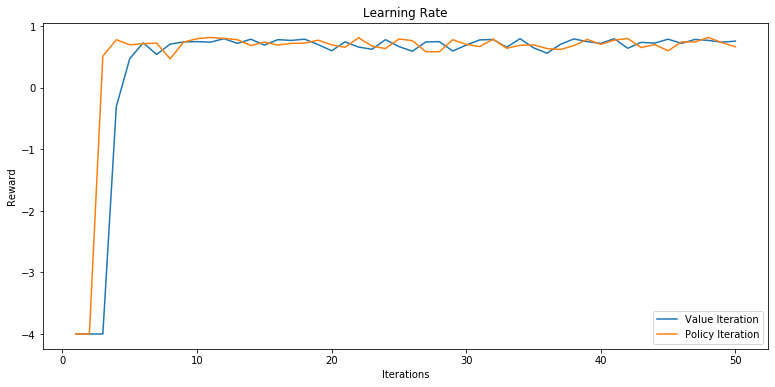

In [7]:
envname = "LavaFloor-v0"
#envname = "HugeLavaFloor-v0"
maxiters = 50

env = gym.make(envname)

series = []  # Series of learning rates to plot
liters = np.arange(maxiters + 1)  # Learning iteration values
liters[0] = 1
elimit = 100  # Limit of steps per episode
rep = 10  # Number of repetitions per iteration value
virewards = np.zeros(len(liters))  # Rewards array
c = 0

t = timer()

# Value iteration
for i in tqdm(liters, desc="Value Iteration", leave=True):
    reprew = 0
    policy = value_iteration(env, maxiters=i)  # Compute policy
    # Repeat multiple times and compute mean reward
    for _ in range(rep):
        reprew += run_episode(env, policy, elimit)  # Execute policy
    virewards[c] = reprew / rep
    c += 1
series.append({"x": liters, "y": virewards, "ls": "-", "label": "Value Iteration"})

vmaxiters = 5  # Max number of iterations to perform while evaluating a policy
pirewards = np.zeros(len(liters))  # Rewards array
c = 0

# Policy iteration
for i in tqdm(liters, desc="Policy Iteration", leave=True):
    reprew = 0
    policy = policy_iteration(env, maxiters=i)  # Compute policy
    # Repeat multiple times and compute mean reward
    for _ in range(rep):
        reprew += run_episode(env, policy, elimit)  # Execute policy
    pirewards[c] = reprew / rep
    c += 1
series.append({"x": liters, "y": pirewards, "ls": "-", "label": "Policy Iteration"})

print("Execution time: {0}s".format(round(timer() - t, 4)))
np.set_printoptions(linewidth=10000)

plot(series, "Learning Rate", "Iterations", "Reward")

Correct results for comparison can be found here below. Notice that since the executions are stochastic the charts could differ: the important thing is the global trend and the final convergence to an optimal solution.

**Standard Lava Floore results comparison**
<img src="images/results-standard.png" width="600">

**Huge Lava Floore results comparison**
<img src="images/results-huge.png" width="600">